# Different Alpha in the activation functions 

In [24]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from utils_activation_FO import *
from utils import model, preprocessing, plots
from pathlib import Path
from numpy.lib.stride_tricks import sliding_window_view
# ================= LOAD DATA =================
data = pd.read_csv("data/signals_FO.csv")

in1 = data['in1'].to_numpy()
in2 = data['in2'].to_numpy()
out = data['out'].to_numpy()


In [27]:
N_REGRESSORS = 3
N_STEPS_AHEAD = 120
ACT_FUN = 'relu'

# ================= NARX FORM =================
# X(t) = [in1(t), in2(t), out(t-1)]
# y(t) = out(t)

X = np.column_stack([
    in1[1:],      # in1(t)
    in2[1:],      # in2(t)
    out[:-1]      # out(t-1)
])

y = out[1:]      # out(t)

# df = preprocessing.create_lagged(data, num_lags= 3)
# X = df.drop(columns=['out']).to_numpy()
# y = df['out'].values



X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, shuffle=False
)




In [28]:
# Input scaling
x_scaler = StandardScaler()
X_train = x_scaler.fit_transform(X_train.reshape(X_train.shape[0], -1))

X_test = x_scaler.transform(X_test.reshape(X_test.shape[0], -1))


# Output scaling (regresija!)
y_scaler = StandardScaler()
y_train = y_scaler.fit_transform(y_train.reshape(-1, 1))
y_test = y_scaler.transform(y_test.reshape(-1, 1))


In [29]:
# ============== SETUP =============
num_input = X_train.shape[1]   
num_output = y_train.shape[1]   
seed2 = 10
num_hidden_layers = 2
num_hidden = 10 # or num_hidden = [10] * num_hidden_layers

### num_hidden can be an int (same for all layers) or a list (different for each layer) 
### num_hidden_layers is the number of hidden layers (not counting the output layer)

# M1 : Classical Activation Functions 
model_fixed = model.fixed(num_input, num_hidden, num_output, num_hidden_layers=num_hidden_layers, activation=ACT_FUN)
model_fixed.compile(
    optimizer="adam",
    loss="mse",
    metrics=["mae"]
)


# M2 : Shared alpha per-layer
model_per_layer = model.per_layer(num_input, num_hidden, num_output, num_hidden_layers=num_hidden_layers, act=ACT_FUN, seed=seed2)
model_per_layer.compile(
    optimizer="adam",
    loss="mse",
    metrics=["mae"]
)


# M3 : Per-neuron alpha
model_per_neuron = model.per_neuron(num_input, num_hidden, num_output, num_hidden_layers=num_hidden_layers, activation=ACT_FUN, seed=seed2)
model_per_neuron.compile(
    optimizer="adam",
    loss="mse",
    metrics=["mae"]
)


In [30]:
alpha_before = {
    'per_layer': model.get_initial_alpha(model_per_layer),
    'per_neuron': model.get_initial_alpha(model_per_neuron)
}

In [31]:
models = {
    "fixed": model_fixed,
    "per_layer": model_per_layer,
    "per_neuron": model_per_neuron
}


In [32]:
EPOCHS = 100
BATCH_SIZE = 32
histories = model.train_models(X_train, y_train, models, EPOCHS=EPOCHS, BATCH_SIZE=BATCH_SIZE, show_progress=True, EarlyStopping=True)

# EarlyStopping is a flag used to include the EarlyStopping callback during training, which helps prevent overfitting by stopping the training process 
# when the validation loss stops improving and also to reduce the training time by avoiding unnecessary epochs once the model has converged.

Training models: 100%|██████████| 3/3 [00:46<00:00, 15.60s/it]


In [33]:
alpha_after = {
    'per_layer': model.get_trained_alpha(model_per_layer),
    'per_neuron': model.get_trained_alpha(model_per_neuron)
}

In [34]:
model.print_alpha(alpha_before, alpha_after, models, type='per_neuron')

Per-neuron alpha:
Layer 'per_neuron_relu_2':
Before: [0.7671, -0.9294, -0.3936, -0.3384, -0.0330, 0.2020, -0.7004, 0.8199, 0.7659, -0.8920,]
After:  [0.1910, 0.0167, -0.0098, -0.0012, 0.2261, 0.0387, -0.1763, 0.1551, 0.2809, -0.4450,]
Layer 'per_neuron_relu_3':
Before: [-0.0173, -0.6909, -0.8147, -0.0454, 0.3206, -0.4877, -0.5124, 0.1962, -0.4083, -0.3074,]
After:  [-0.0669, -0.1404, -0.1842, -0.1400, 0.2720, -0.2847, 0.0123, 0.0225, 0.0398, -0.2052,]


In [35]:
model.print_alpha(alpha_before, alpha_after, models, type='per_layer')

Per-layer alpha:
Layer 'per_layer_relu_1':
Before: [0.4639]
After:  [0.0512]
Layer 'per_layer_relu_1':
Before: [0.4639]
After:  [0.0512]


In [36]:
model.print_alpha(alpha_before, alpha_after, models, type='comparison')

Per-layer alpha:
Layer 'per_layer_relu_1':
Before: [0.4639]
After:  [0.0512]
Layer 'per_layer_relu_1':
Before: [0.4639]
After:  [0.0512]


Per-neuron alpha:
Layer 'per_neuron_relu_2':
Before: [0.7671, -0.9294, -0.3936, -0.3384, -0.0330, 0.2020, -0.7004, 0.8199, 0.7659, -0.8920,]
After:  [0.1910, 0.0167, -0.0098, -0.0012, 0.2261, 0.0387, -0.1763, 0.1551, 0.2809, -0.4450,]
Layer 'per_neuron_relu_3':
Before: [-0.0173, -0.6909, -0.8147, -0.0454, 0.3206, -0.4877, -0.5124, 0.1962, -0.4083, -0.3074,]
After:  [-0.0669, -0.1404, -0.1842, -0.1400, 0.2720, -0.2847, 0.0123, 0.0225, 0.0398, -0.2052,]


In [37]:
p = plots(histories, models, X_test, y_test, y_scaler, save_path=f"./results/{ACT_FUN}/")
metrics = p.print_final_metrics(save=True)

FINAL EVALUATION METRICS

Model Fixed:
  Test MSE: 0.000028
  Test MAE: 0.003949

Model Per-Layer:
  Test MSE: 0.000051
  Test MAE: 0.005010

Model Per-Neuron:
  Test MSE: 0.000029
  Test MAE: 0.003588


In [38]:
metrics # Saving the metrics into a dataframe for easier comparison and exporting to csv for further analysis.


,Model,MSE,MAE
0,Fixed,0.000028,0.003949
1,Per-Layer,0.000051,0.005010
2,Per-Neuron,0.000029,0.003588


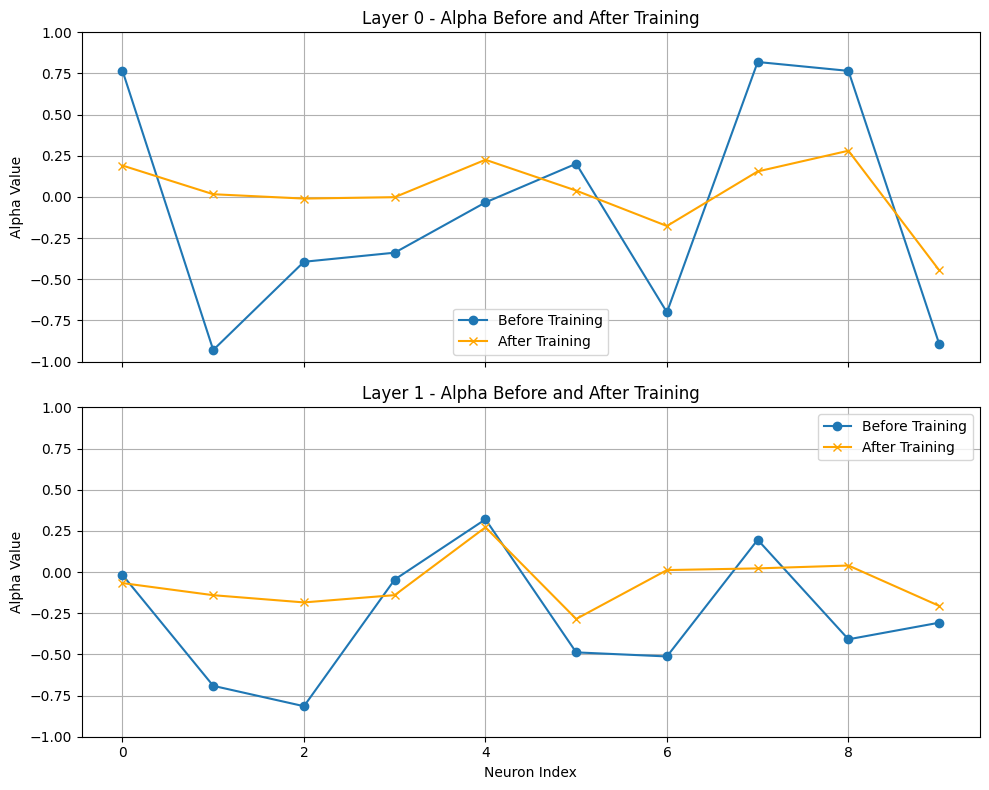

In [39]:
p.plot_alpha_comparison(alpha_before, alpha_after, save=True)

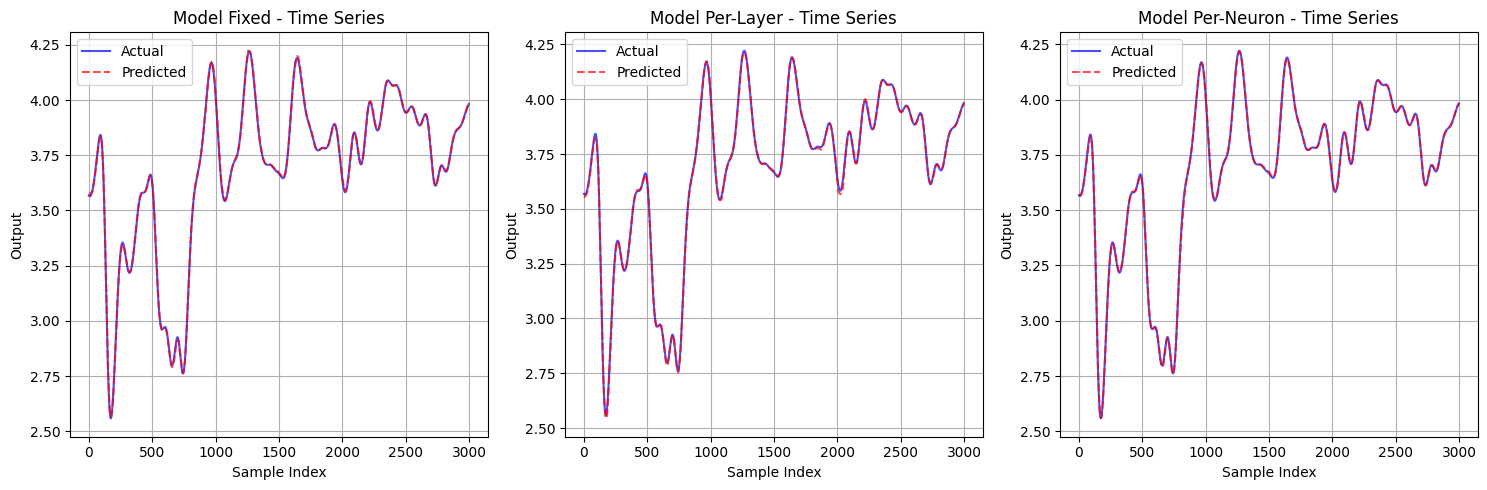

In [40]:
p.plot_time_series(sample_size=-1, save=True)  #You can set sample_size to a specific number to plot only a subset of the time series, or -1 to plot the entire series.

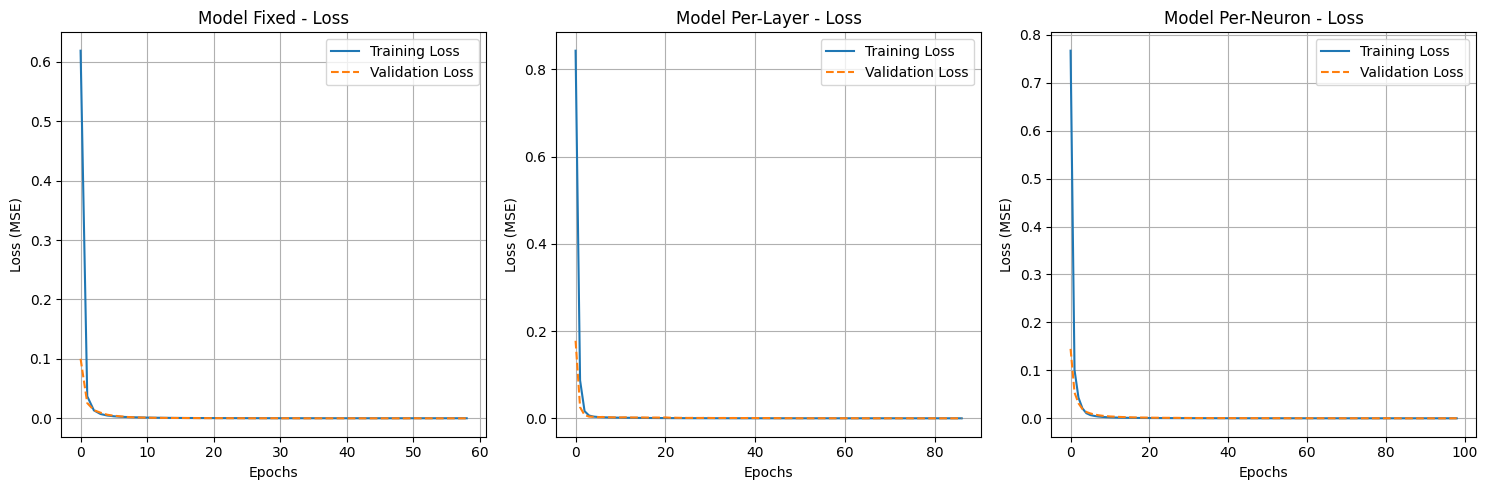

In [41]:
p.plot_history(save=True)

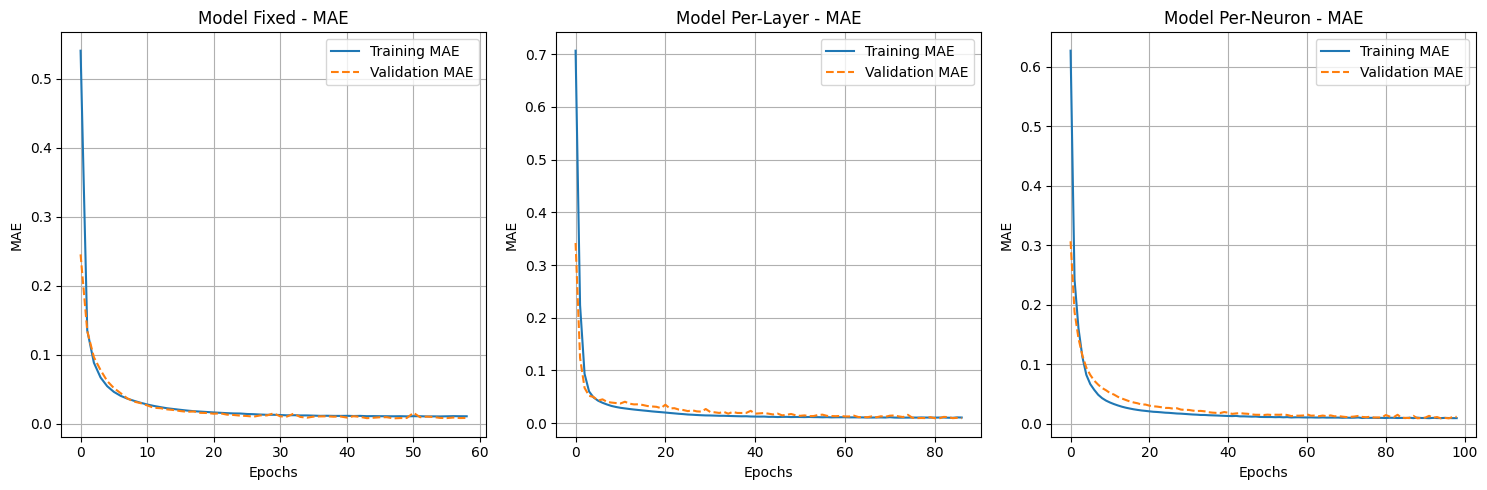

In [42]:
p.plot_mae(save=True)

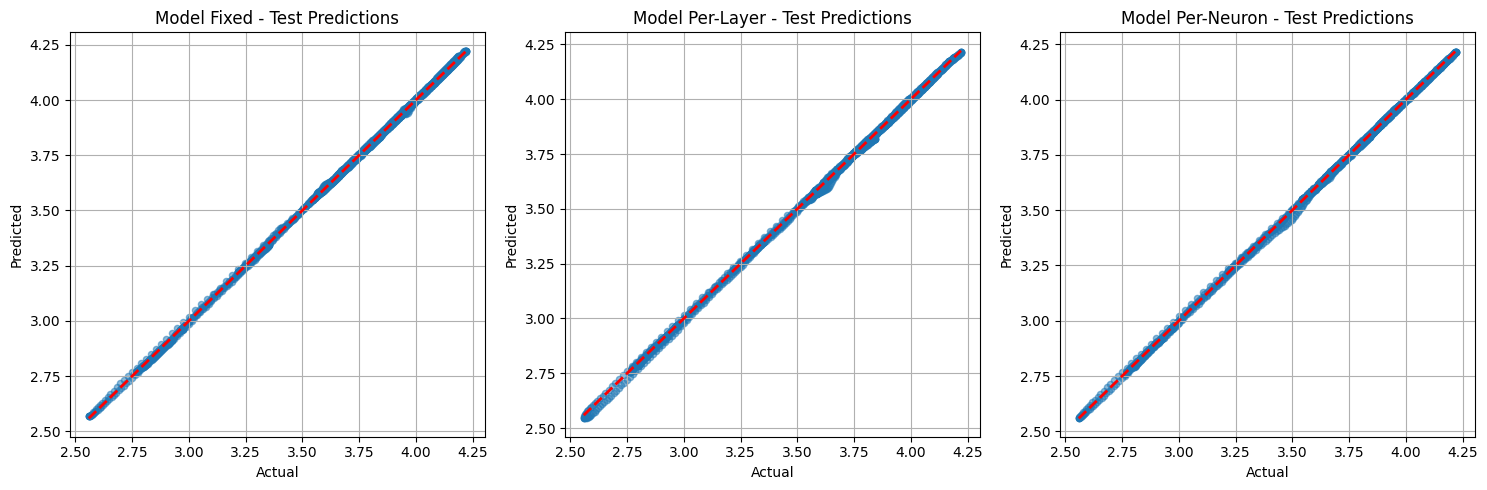

In [43]:
p.plot_predictions(save=True)